<a href="https://colab.research.google.com/github/movindugunarathna/sinXdetect/blob/main/ml/bert_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Required Libraries

In [1]:
%pip install -q tf-keras
%pip install -q transformers
%pip install -q datasets
%pip install -q nltk
%pip install -q scikit-learn
%pip install -q matplotlib

## 2. Import Required Libraries

In [2]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow deprecation warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

## 3. Load Dataset from JSONL Files

In [3]:
def get_gdrive_dataset_dir(subpath='dataset'):
    """Try to mount Google Drive (Colab) and return full path to `subpath`.
    Fallbacks:
      - Use GDRIVE_DATASET_PATH env var if set and exists.
      - Use a local folder named `subpath` in the current working directory.
    Raise a clear error if none of the above work.
    """
    # Try Colab mount
    try:
        from google.colab import drive  # type: ignore
        drive.mount('/content/drive', force_remount=False)
        base = '/content/drive/MyDrive'
        candidate = os.path.join(base, subpath)
        if os.path.exists(candidate):
            return candidate
        # If subpath not found under MyDrive, allow using absolute path provided by user in MyDrive
        raise FileNotFoundError(f"Expected folder at {candidate} not found in Google Drive.")
    except Exception:
        # Fallback to environment variable
        env_path = os.environ.get('GDRIVE_DATASET_PATH')
        if env_path and os.path.exists(env_path):
            return env_path
        # Fallback to local 'dataset' folder inside current working dir
        local_candidate = os.path.join(os.getcwd(), subpath)
        if os.path.exists(local_candidate):
            return local_candidate
        raise RuntimeError(
            "Could not mount Google Drive or locate dataset folder. "
            "If running locally, set the environment variable GDRIVE_DATASET_PATH "
            "to the dataset folder path or place a 'dataset' folder in the notebook cwd."
        )

def load_jsonl(filepath):
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

# Resolve dataset directory (will attempt to mount Drive on Colab)
dataset_dir = get_gdrive_dataset_dir('dataset')

# Load training, validation, and test datasets from the resolved directory
train_data = load_jsonl(os.path.join(dataset_dir, 'train.jsonl'))
val_data = load_jsonl(os.path.join(dataset_dir, 'val.jsonl'))
test_data = load_jsonl(os.path.join(dataset_dir, 'test.jsonl'))

print(f"Dataset directory: {dataset_dir}")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Mounted at /content/drive
Dataset directory: /content/drive/MyDrive/dataset
Training set size: 72364
Validation set size: 9045
Testing set size: 9048


## 4. Convert JSONL to DataFrame and Preprocess

In [4]:
# Convert to DataFrame
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Display sample data
print("Sample training data:")
print(train_df[['text', 'label']].head())
print(f"\nLabel value counts (Train):")
print(train_df['label'].value_counts())

Sample training data:
                                                text  label
0  මත්ද්‍රව්‍ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස්...     AI
1  ශ්‍රී ලංකාවේ නව කැබිනට් මණ්ඩලයේ සංශෝධනය පිළිබඳ...     AI
2  2012 පෙබරවාරි මාසයේ වැල්ලම්පිටියේ දී යුද හමුදා...  HUMAN
3  (මනෝප්‍රිය ගුණසේකර)කතෝලික දේවස්ථාන හා තරුපහේ හ...  HUMAN
4  මැතිවරණ කොමිසම වෙත මැතිවරණ ආශ්‍රිත පැමිණිලි 45...     AI

Label value counts (Train):
label
HUMAN    39848
AI       32516
Name: count, dtype: int64


## 5. Map Labels to Numeric Values

In [5]:
# Create label mapping
label_mapping = {'HUMAN': 0, 'AI': 1}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Map labels to numeric values
train_df['label_encoded'] = train_df['label'].map(label_mapping)
val_df['label_encoded'] = val_df['label'].map(label_mapping)
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Check for any unmapped values
print(f"Train - Unmapped labels: {train_df['label_encoded'].isna().sum()}")
print(f"Val - Unmapped labels: {val_df['label_encoded'].isna().sum()}")
print(f"Test - Unmapped labels: {test_df['label_encoded'].isna().sum()}")

Train - Unmapped labels: 0
Val - Unmapped labels: 0
Test - Unmapped labels: 0


## 6. Text Preprocessing

In [6]:
def expand_contractions(text):
    """Expand common English contractions"""
    contractions = {
        "I'm": "I am",
        "you're": "you are",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "we're": "we are",
        "they're": "they are",
        "can't": "cannot",
        "won't": "will not",
        "didn't": "did not",
        "doesn't": "does not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "aren't": "are not",
        "weren't": "were not",
        "couldn't": "could not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "gonna": "going to"
    }

    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expanded, text)

    return text

# Apply text preprocessing
print("Preprocessing training data...")
train_df['expanded_text'] = train_df['text'].apply(expand_contractions)

print("Preprocessing validation data...")
val_df['expanded_text'] = val_df['text'].apply(expand_contractions)

print("Preprocessing test data...")
test_df['expanded_text'] = test_df['text'].apply(expand_contractions)

print("Preprocessing complete!")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...
Preprocessing complete!


## 7. Load BERT Tokenizer

In [7]:
# Load MobileBERT tokenizer (very lightweight model, ~150MB, supports multilingual)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('google/mobilebert-uncased')
print("MobileBERT tokenizer loaded successfully!")

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

MobileBERT tokenizer loaded successfully!


## 8. Tokenize and Encode Text Data

In [8]:
# Tokenize and encode the text data using tokenizer in batches to avoid memory spikes
print("Tokenizing data in batches...")

def tokenize_in_batches(texts, tokenizer, batch_size=32, max_length=512):
    """Tokenize a list of texts in small batches and return numpy arrays.
    Returns a dict with 'input_ids' and 'attention_mask' as numpy arrays.
    Pads every batch to `max_length` so concatenation shapes match.
    """
    input_ids_parts = []
    attention_mask_parts = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding='max_length',   # pad each batch to the fixed max_length
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )
        # Convert to numpy to keep memory usage predictable and avoid nested lists
        ids = enc['input_ids'].numpy()
        mask = enc['attention_mask'].numpy()

        # Sanity check: ensure shape[1] == max_length
        if ids.shape[1] != max_length:
            # If tokenizer produced a different length for some reason, force-pad/truncate
            ids = np.pad(ids, ((0,0),(0,max_length-ids.shape[1])), constant_values=0)[:,:max_length]
            mask = np.pad(mask, ((0,0),(0,max_length-mask.shape[1])), constant_values=0)[:,:max_length]

        input_ids_parts.append(ids)
        attention_mask_parts.append(mask)

    input_ids = np.concatenate(input_ids_parts, axis=0)
    attention_mask = np.concatenate(attention_mask_parts, axis=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# Run batched tokenization
train_encodings = tokenize_in_batches(train_df['expanded_text'].tolist(), tokenizer, batch_size=32)
val_encodings = tokenize_in_batches(val_df['expanded_text'].tolist(), tokenizer, batch_size=32)
test_encodings = tokenize_in_batches(test_df['expanded_text'].tolist(), tokenizer, batch_size=32)

print("Tokenization complete!")
print(f"Training encodings shape: {train_encodings['input_ids'].shape}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing data in batches...
Tokenization complete!
Training encodings shape: (72364, 512)


## 9. Prepare Labels

In [9]:
# Extract input arrays and convert labels to numpy arrays
# Use dicts with both input_ids and attention_mask so the model gets both inputs
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}
test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}

# Convert labels to numpy arrays
train_labels = np.array(train_df['label_encoded'].astype(int).tolist())
val_labels = np.array(val_df['label_encoded'].astype(int).tolist())
test_labels = np.array(test_df['label_encoded'].astype(int).tolist())

print(f"Train labels shape: {train_labels.shape}")
print(f"Val labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nLabel distribution (Train): {np.bincount(train_labels)}")
print(f"Label distribution (Val): {np.bincount(val_labels)}")
print(f"Label distribution (Test): {np.bincount(test_labels)}")

Train labels shape: (72364,)
Val labels shape: (9045,)
Test labels shape: (9048,)

Label distribution (Train): [39848 32516]
Label distribution (Val): [4981 4064]
Label distribution (Test): [4982 4066]


## 10. Define BERT Classification Model

In [10]:
# Load pre-trained MobileBERT model for sequence classification (very lightweight, ~150MB)
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    'google/mobilebert-uncased',
    num_labels=2  # Binary classification: HUMAN (0) vs AI (1)
)

print("MobileBERT model loaded successfully!")

tf_model.h5:   0%|          | 0.00/164M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBERT model loaded successfully!


## 11. Compile the Model

In [11]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

print("Model compiled successfully!")
print("\nModel Summary:")
model.summary()

Model compiled successfully!

Model Summary:
Model: "tf_mobile_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilebert (TFMobileBertMa  multiple                  24581888  
 inLayer)                                                        
                                                                 
 dropout_49 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1026      
                                                                 
Total params: 24582914 (93.78 MB)
Trainable params: 24582914 (93.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 12. Train the BERT Model

In [12]:
# Train the BERT model
print("Training the model...")
history = model.fit(
    train_inputs,
    train_labels,
    epochs=3,  # Reduced epochs due to large dataset size
    batch_size=16,
    validation_data=(val_inputs, val_labels),
    verbose=1
)

print("\nTraining completed!")

Training the model...
Epoch 1/3
4523/4523 [==============================] - 4080s 842ms/step - loss: 161.1740 - accuracy: 0.7870 - val_loss: 0.1755 - val_accuracy: 0.9401
Epoch 2/3
4523/4523 [==============================] - 3792s 838ms/step - loss: 0.1152 - accuracy: 0.9600 - val_loss: 0.0673 - val_accuracy: 0.9763
Epoch 3/3
4523/4523 [==============================] - 3794s 839ms/step - loss: 0.0593 - accuracy: 0.9805 - val_loss: 0.0963 - val_accuracy: 0.9703

Training completed!


## 13. Save the Trained Model

In [13]:
# Save the entire trained model
model.save_pretrained("models/bert_multilingual/")
print("Model saved to models/bert_multilingual/")

# Also save the tokenizer
tokenizer.save_pretrained("models/bert_multilingual/")
print("Tokenizer saved to models/bert_multilingual/")

Model saved to models/bert_multilingual/
Tokenizer saved to models/bert_multilingual/


## 14. Evaluate on Validation Set

In [14]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels, verbose=0)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 0.0963
Validation Accuracy: 0.9703


## 15. Evaluate on Test Set

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0890
Test Accuracy: 0.9730


## 16. Plot Training and Validation Accuracy

FileNotFoundError: [Errno 2] No such file or directory: 'results/training_history.png'

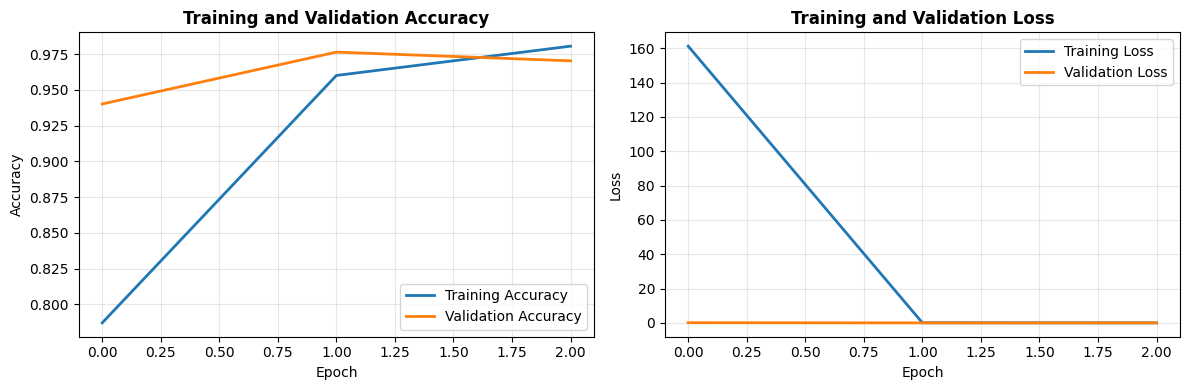

In [16]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("Training history plot saved!")

## 17. Generate Predictions and Confusion Matrix

283/283 [==============================] - 181s 600ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'results/confusion_matrix.png'

<Figure size 800x600 with 0 Axes>

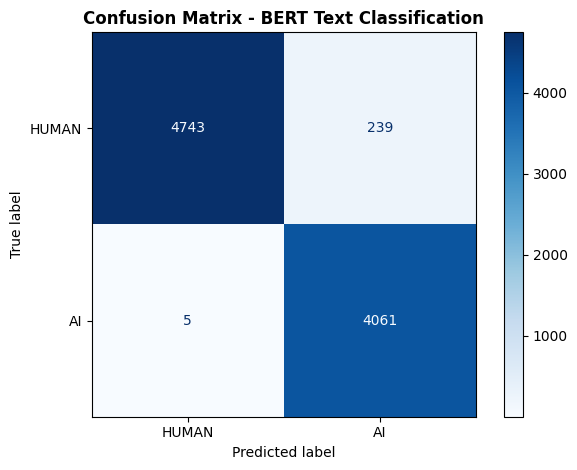

In [17]:
# Predict labels for the test set
predictions = model.predict(test_inputs)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['HUMAN', 'AI'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - BERT Text Classification', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

## 18. Calculate ROC Curve and AUC Score

FileNotFoundError: [Errno 2] No such file or directory: 'results/roc_curve.png'

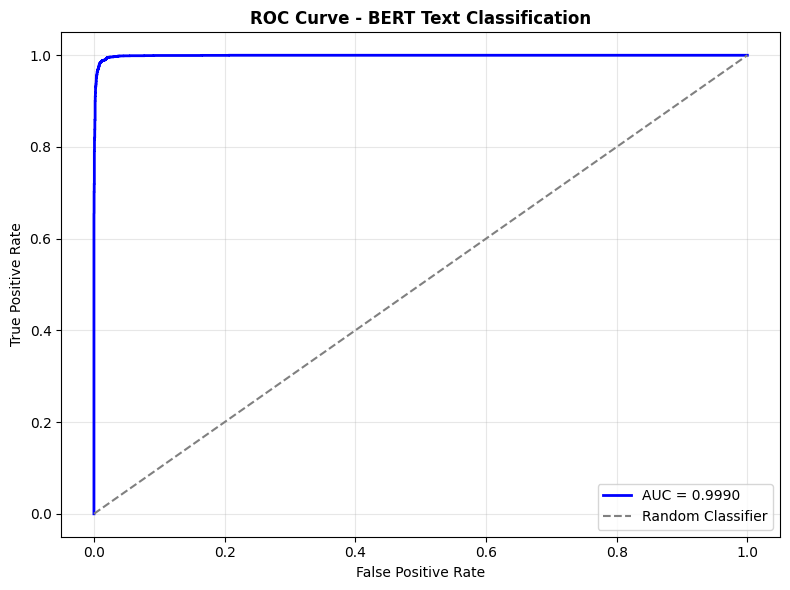

In [18]:
# Get probabilities for positive class (AI)
probabilities = tf.nn.softmax(predictions.logits)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(test_labels, probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', linewidth=2, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT Text Classification', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/roc_curve.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"AUC Score: {auc_score:.4f}")

## 19. Classification Report

In [19]:
# Generate detailed classification report
report = classification_report(
    test_labels,
    predicted_labels,
    target_names=['HUMAN', 'AI'],
    digits=4
)

print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(report)
print("="*60)


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

       HUMAN     0.9989    0.9520    0.9749      4982
          AI     0.9444    0.9988    0.9708      4066

    accuracy                         0.9730      9048
   macro avg     0.9717    0.9754    0.9729      9048
weighted avg     0.9744    0.9730    0.9731      9048



## 20. Summary of Model Performance

In [20]:
# Create a summary of model performance
summary_data = {
    'Metric': ['Test Accuracy', 'Test Loss', 'AUC Score'],
    'Value': [f'{test_accuracy:.4f}', f'{test_loss:.4f}', f'{auc_score:.4f}']
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)

# Save summary
summary_df.to_csv('results/model_performance_summary.csv', index=False)
print("\nPerformance summary saved to results/model_performance_summary.csv")


MODEL PERFORMANCE SUMMARY
       Metric  Value
Test Accuracy 0.9730
    Test Loss 0.0890
    AUC Score 0.9990


OSError: Cannot save file into a non-existent directory: 'results'